# Profanity Detection using Machine Learning

## Prerequisites

Mounting the folder where datasets are located

In [ ]:
from google.colab import drive
import torch, os
drive.mount('/content/drive')
device = torch.device("cuda")
os.chdir('/content/drive/MyDrive/Final Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing required libraries

In [ ]:
!pip install transformers
!pip install   liac-arff 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install sentencepiece


Importing the requirements

In [ ]:
import os, pandas as pd, numpy as np, arff
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler,BatchSampler
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import AdamW
from transformers import BertTokenizer, BertModel, XLMRobertaTokenizerFast
from transformers import get_linear_schedule_with_warmup

#XLM-Roberta
from transformers import AutoTokenizer 
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import XLMRobertaForSequenceClassification

## Preparing the data

Define functions for loading all the selected datasets with the same structure. All functions return the training and test sets seperately. Stratified splitting strategy has been applied to ensure that equal amounts of hateful and non-hateful inputs appear across both training and test sets.

In [ ]:
def LoadAntiSocialArabic():

  df2 = pd.read_excel("Arabic/antisocial-arabic/LabeledDataset.xlsx")
  df = pd.DataFrame()
  df["input"] = df2["commentText"]
  df['hate'] = df2['Label'].map(lambda x: 1 if x=='P' else 0)
  df =df.dropna()
  df = df[["input", 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def split(dataframe):
  from sklearn.model_selection import StratifiedShuffleSplit
  dataframe = dataframe.reset_index()
  X = dataframe['input']
  y=dataframe['hate']
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
  splits = sss.split(X, y)
  for a, b in splits:
    train_index, test_index = a, b
    break
  X_train, y_train, X_test, y_test =  X[train_index].tolist(), y[train_index].tolist(),X[test_index].tolist(), y[test_index].tolist()
  #X_train, y_train = fixImbalance (X_train, y_train)
  
  return X_train, y_train, X_test, y_test 

def fixImbalance(X, y):
  # here, we are mainly oversampling since sampling strategy is 1 and oversampler is appied before

  # instantiating over and under sampler
  over = RandomOverSampler(sampling_strategy=1)
  under = RandomUnderSampler(sampling_strategy=1)
  # first performing oversampling to minority class
  
  X_over, y_over = over.fit_resample(np.array(X).reshape(-1, 1), np.array(y).reshape(-1, 1))
  X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
  return X_combined_sampling.flatten().tolist(), y_combined_sampling.flatten().tolist()

def LoadOffenseEval2020_Arabic():

  labels = pd.read_csv("./Arabic/offenseval2020-arabic/offenseval-ar-testset-v1/offenseval-ar-labela-v1.csv")
  labels = pd.concat([labels, pd.DataFrame([labels.columns], columns = labels.columns) ])
  labels =labels.reset_index()[labels.columns]
  labels.columns = ['id', 'hate']
  labels.index = labels['id'].astype(int).tolist()
  labels =labels.sort_index()


  train = pd.read_csv("./Arabic/offenseval2020-arabic/offenseval-ar-training-v1/offenseval-ar-training-v1.tsv",  sep='\t')
  train = train[["tweet", "subtask_a"]]
  train.columns =["input", 'hate']
  train['hate'] = train['hate'].map(lambda x: 1 if x =='OFF' else 0)
  test = pd.read_csv("./Arabic/offenseval2020-arabic/offenseval-ar-testset-v1/offenseval-ar-test-v1.tsv",  sep='\t')

  test.index = test['id'].astype(int).tolist()
  test = test.sort_index()
  test['hate'] = labels['hate']
  test['hate']=pd.concat([test,labels], keys=['id'])["hate"]['id']
  test['hate'] = test['hate'].map(lambda x: 1 if x =='OFF' else 0)

  test.columns = ['id', 'input', 'hate']
  
  X_train, y_train, X_test, y_test =  train['input'].tolist(),  train['hate'].tolist(),test['input'].tolist(),  test['hate'].tolist()
  return X_train, y_train, X_test, y_test

def LoadOffenseEval2020_Dannish():
  train = pd.read_csv("./Dannish/offenseval2020-dannish/oe20da_data/offenseval-da-training-v1.tsv", sep='\t')
  train['hate'] = train['subtask_a'].map(lambda x: 1 if x=='OFF' else 0)
  train['input'] = train['tweet']
  train = train.dropna().reset_index()
  train = train[['input', 'hate']]


  test = pd.read_csv("./Dannish/offenseval2020-dannish/oe20da_data/offenseval-da-test-v1.tsv", sep='\t')
  test['hate'] = test['subtask_a'].map(lambda x: 1 if x=='OFF' else 0)
  test['input'] = test['tweet']
  test = test.dropna().reset_index()
  test = test[['input', 'hate']]
  X_train, y_train, X_test, y_test =  train['input'].tolist(),  train['hate'].tolist(),test['input'].tolist(),  test['hate'].tolist()
  return X_train, y_train, X_test, y_test


def LoadOffenseEval2020_Turkish():
  train = pd.read_csv("./Turkish/offenseval2020-turkish/offenseval-tr-training-v1/offenseval-tr-training-v1.tsv", sep='\t')
  train['hate'] = train['subtask_a'].map(lambda x: 1 if x=='OFF' else 0)
  train['input'] = train['tweet']
  train = train.dropna().reset_index()
  train = train[['input', 'hate']]

  test = pd.read_csv("./Turkish/offenseval2020-turkish/offenseval-tr-testset-v1/offenseval-tr-testset-v1.tsv", sep='\t')
  labels = pd.read_csv("./Turkish/offenseval2020-turkish/offenseval-tr-testset-v1/offenseval-tr-labela-v1.tsv", sep=',')

  labels = pd.concat([labels, pd.DataFrame([labels.columns], columns = labels.columns) ])
  labels =labels.reset_index()[labels.columns]
  labels.columns = ['id', 'hate']
  labels.index = labels['id'].astype(int).tolist()
  labels =labels.sort_index()

  test.index = test['id'].astype(int).tolist()
  test = test.sort_index()
  test['hate'] = labels['hate']
  test['hate']=pd.concat([test,labels], keys=['id'])["hate"]['id']
  test['hate'] = test['hate'].map(lambda x: 1 if x =='OFF' else 0)

  test.columns = ['id', 'input', 'hate']
  X_train, y_train, X_test, y_test =  train['input'].tolist(),  train['hate'].tolist(),test['input'].tolist(),  test['hate'].tolist()
  return X_train, y_train, X_test, y_test

def LoadOffComBR_Portugese():
  data = np.array(arff.load(open('./Portugese/OffComBR/OffComBR3.arff.txt', 'r'))['data'])
  df =pd.DataFrame(data)
  df.columns =['hate', 'input']
  df['hate'] = df['hate'].map(lambda x : 1 if x=='yes' else 0)
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test


def LoadIWG_German():
  df = pd.read_csv("./German/IWG_hatespeech_public//german hatespeech refugees.csv")
  df.columns =['input', 'r1', 'r2', 'r3']
  df['r3'] = df['r3'].map(lambda x: 1 if x>3 else 0)
  df['r1'] = df['r1'].map(lambda x: 1 if (x=='YES') else 0)
  df['r2'] = df['r2'].map(lambda x: 1 if (x=='YES') else 0)
  df['hate'] = df.apply(lambda row: 1 if (row.r1+row.r2+row.r3)>=2 else 0, axis=1)
  df = df[['hate','input'] ]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def LoadGermEval2018():
  df =pd.read_csv("./German/germeval2018/germeval2018.training.txt", sep='\t',header=None)
  df.columns =['input', 'a', 'b']
  df['hate'] = df['a'].map(lambda x: 0 if x=='OTHER' else 1)
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_FR_MLMA():
  df =pd.read_csv("./French/MLMA_hate_speech/hate_speech_mlma/fr_dataset.csv", sep=',')
  df.columns =['id','input', 'a', 'b', 'c', 'd', 'e']
  df['hate'] = df['a'].map(lambda x: 0 if x=='normal' else 1)
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_IT_IHSC():
  df =pd.read_csv("./Italian/IHSC/data.csv", sep=',')
  df.columns =['id','input', 'a']
  df['hate'] = pd.to_numeric(df["a"])
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_ES_Pereira():
  df =pd.read_csv("./Spanish/Pereira et al/labeled_corpus_6K.txt", sep=';\|\|;', header=None)
  df.columns =['id','input', 'a']
  df['hate'] = pd.to_numeric(df["a"])
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_ES_violentometro():
  df =pd.read_csv("./Spanish/violentometro-online/data/clean_comentarios_facebook.csv", sep=',')
  df.columns =['input', 'a']
  df['hate'] = pd.to_numeric(df["a"])
  df = df.dropna()
  df = df.sample(frac=1).reset_index(drop=True)
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_distilaltion_it():
  df =pd.read_csv("./Distillation/IMSypp_IT.csv", sep=',')
  df.columns =['input', 'a']
  df['hate'] = pd.to_numeric(df["a"])
  df = df.dropna()
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

def load_distilaltion_fr():
  df =pd.read_csv("./Distillation/IMSypp_FR.csv", sep=',')
  df.columns =['input', 'a']
  df['hate'] = pd.to_numeric(df["a"])
  df = df.dropna()
  df= df[['input', 'hate']]
  X_train, y_train, X_test, y_test = split(df)
  return X_train, y_train, X_test, y_test

Loading all the datasets.

In [ ]:
datasets ={
  'Arabic': {
    'antisocial-arabic': LoadAntiSocialArabic(),
    'offenseval2020-arabic': LoadOffenseEval2020_Arabic()
  },
 'Dannish': {
    'offenseval2020-dannish': LoadOffenseEval2020_Dannish()
  },
 'German': {
     'IWG_hatespeech_public': LoadIWG_German(),
     'germeval2018': LoadGermEval2018()
  },
 'Portugese': {
     'OffComBR': LoadOffComBR_Portugese()
  },
 'Turkish': {
     'offenseval2020-turkish': LoadOffenseEval2020_Turkish()
  },
  'French': {
      'mlma_hate_speech': load_FR_MLMA()
  },
  'Italian': {
      'ihsc': load_IT_IHSC()
  },
  'Spanish': {
      'pereira': load_ES_Pereira(),
      'violentometro': load_ES_violentometro()
  }
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Defines a function to freeze a selected number of layers for the model.

In [ ]:
def freeze(model, n_layers):
  for param in model.embeddings.parameters():
    param.requires_grad = False
  for i, layer in enumerate(model.encoder.layer):
      if i < n_layers:
        print("Freezing layer", i)
        for param in layer.parameters():
          param.requires_grad = False
      else:
        param.requires_grad = True
  return model

## Solution 1

This solution proposes to use a multilingual neural network-based model that is trained to generate multilingual representations. Here we have created two models based on mBERT and XML-RoBERTa to evaluate this approach.

### Model 1 - mBERT


Defines the class for the ProfanityDetector model based on mBERT

In [ ]:
class ProfanityDetector_mBERT(torch.nn.Module):
  def __init__(self, bert):
    super(ProfanityDetector_mBERT, self).__init__()

    # Pretrained bert model
    self.bert =  bert; 

    self.drop = nn.Dropout(p=0.1)
    
    # One layer that accepts the CLS vector and outputs 2 values => hate or no hate
    self.linear1 = torch.nn.Linear(768, 2)  
 
    # To compute whether it is hateful or not
    self.CrossEntropyLoss = nn.CrossEntropyLoss() 

    self.Softmax = torch.nn.Softmax() 

  def embed(self, input_ids, attention_masks):
    """
    Inputs:
      - input_ids: array of tensors, where every row corresponds to the token ids of a certain textual data
      - attention_masks: array of tensors, where every row corresponds to an attention mask (which tokens should be attended to, and which should not)
    (These inputs are the outputs of the BERT tokenizer)

    Output: 
      - the embeddings of the data inputted by getting the cls token
    """
    self.bert.eval() 
    output = self.bert(input_ids=input_ids, attention_mask=attention_masks)
    token_embeddings = output[0]
    cls_rep = token_embeddings[:, 0, :]
    return output[1] 

  
  def forward(self, input_ids, attention_masks):

    """
    Inputs: 
      - input_ids, attention_masks : list of input_ids and attention_masks for a set of sentences
    Output:
      - compute the profanity hate/no hate
    """
    encoded= self.embed(input_ids, attention_masks)

    linear1 = self.drop(self.linear1(encoded))


    return (linear1)

def tokenize_encode_tensors(sentences, max_seq_len):
 tokens = tokenizer.batch_encode_plus(
        sentences,
        max_length = max_seq_len, #
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
 seq =  torch.tensor(tokens['input_ids'])
 mask = torch.tensor(tokens['attention_mask'])

 return seq, mask


Defines a function to plot the results obtained.

In [ ]:
def plotResults(res, language, dataset):
  """
  res: dictionary of the results (accuracy, P, R, F-score ) on each dataset
  language and dataset are used for the caption
  """
  fig, ax = plt.subplots(1, 2, figsize=(20,5))

  langs = list(res.keys())
  acc = [res[key]['accuracy'] for key in res.keys()]
  f_score = [res[key]['f_score'] for key in res.keys()]
  f_score = [f if str(f)!='nan' else 0 for f in f_score]
  y_pos = range(len(langs))
  ax[0].bar(y_pos, acc)
  # Rotation of the bars names
  ax[0].set_xticks(y_pos)
  ax[0].set_xticklabels(langs, minor=False, rotation=90)
  ax[0].set_title("Fine tuned on {} - {}".format(language, dataset))
  ax[0].set_ylabel("Accuracy")
  ax[1].bar(y_pos, f_score)
  # Rotation of the bars names
  ax[1].set_xticks(y_pos)
  ax[1].set_xticklabels(langs, minor=False, rotation=90)
  ax[1].set_title("Fine tuned on {} - {}".format(language, dataset))
  ax[1].set_ylabel("F-Score")

  plt.show()

Defines a function to create the dataloaders for the training and test datasets based on the given batch size and maximum sequence length. Then the mBERT model is loaded. 

In [ ]:
#Prepare data
def createDataLoader(X_train, y_train,  X_test, y_test, max_seq_len,batch_size):
  X_train, y_train = fixImbalance (X_train, y_train)

  seq_train, mask_train = tokenize_encode_tensors(X_train, max_seq_len)
  out_train = torch.tensor(y_train).long()
  # wrap tensors
  train_data = TensorDataset(seq_train, mask_train, out_train)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  seq_test, mask_test = tokenize_encode_tensors(X_test, max_seq_len)
  out_test = torch.tensor(y_test).long()
  # wrap tensors
  test_data = TensorDataset(seq_test, mask_test, out_test)
  test_sampler = RandomSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

  return train_dataloader, test_dataloader

max_seq_len = 64
batch_size = 32

mBert = BertModel.from_pretrained('bert-base-multilingual-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')


with open("datasets_mBERT.dt", 'rb') as f:
  #were saved to save time 
    tensors = pickle.load(f)
# tensors ={}
# for language in datasets.keys():
#   tensors[language] ={}
#   for dataset in datasets[language].keys():
#     tensors[language][dataset] ={}
#     X_train, y_train,  X_test, y_test = datasets[language][dataset]
#     train_dataloader, test_dataloader  = createDataLoader(X_train, y_train,  X_test, y_test,max_seq_len, batch_size)
#     tensors[language][dataset]['train'] = train_dataloader
#     tensors[language][dataset]['test'] = test_dataloader
      


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Defines a function to calculate the accuracy of our prediction verses the labels. Also defines the training and validate function. 

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train_validate( model, dataloader, scheduler, optimizer, train):
  if train: 
    model.train()
  else: 
    model.eval()

  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  i=0  
  acc=[]

  
  target_true =0
  predicted_true =0
  correct_true =0
  for step,batch in enumerate(dataloader):
    i+=1
    if step%20==0 and step != 0 and train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    if step%40==0 and step != 0 and not train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, label = batch

    if train:
      # clear previously calculated gradients 
      model.zero_grad()        

    with torch.set_grad_enabled(train): #only enable when training    
          pred_score = model(sent_id, mask)
    
        
          loss = model.CrossEntropyLoss(model.Softmax(pred_score), label)
          
          
          if train:


            loss.backward() 
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            optimizer.step()

        # Update the learning rate.
            scheduler.step()
            # scheduler.step()
    # push model predictions from GPU to CPU
    pred_score=pred_score.detach().cpu().numpy()
    
    

    total_loss = total_loss + loss.item()
    acc.append(flat_accuracy(pred_score, label.detach().cpu().numpy()))

    predicted_classes = np.argmax(pred_score, axis=1).flatten()
    target_classes = label.detach().cpu().numpy().flatten()

   

    target_true += np.sum(target_classes)
    predicted_true += np.sum(predicted_classes)

    correct_true += np.sum((predicted_classes == target_classes) & (predicted_classes == 1))

    # append the model predictions
    total_preds.append(pred_score)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  acc = np.mean(acc)

  
  recall = correct_true / target_true
  precision = correct_true / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss,acc, precision, recall, f1_score,  total_preds 

def train_validate( model, dataloader, scheduler, optimizer, train):
  if train: 
    model.train()
  else: 
    model.eval()

  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  i=0  
  acc=[]

  
  target_true =0
  predicted_true =0
  correct_true =0
  for step,batch in enumerate(dataloader):
    i+=1
    if step%20==0 and step != 0 and train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    if step%40==0 and step != 0 and not train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, label = batch

    if train:
      # clear previously calculated gradients 
      model.zero_grad()        
      optimizer.zero_grad()
    with torch.set_grad_enabled(train): #only enable when training    
          pred_score = model(sent_id, mask)
          loss = model.CrossEntropyLoss(model.Softmax(pred_score), label)
          
          
          if train:
            loss.backward()             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

    # push model predictions from GPU to CPU
    pred_score=pred_score.detach().cpu().numpy()
    
    total_loss = total_loss + loss.item()
    acc.append(flat_accuracy(pred_score, label.detach().cpu().numpy()))

    predicted_classes = np.argmax(pred_score, axis=1).flatten()
    target_classes = label.detach().cpu().numpy().flatten()

    target_true += np.sum(target_classes)
    predicted_true += np.sum(predicted_classes)
    correct_true += np.sum((predicted_classes == target_classes) & (predicted_classes == 1))

    total_preds.append(pred_score)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  acc = np.mean(acc)

  
  recall = correct_true / target_true
  precision = correct_true / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss,acc, precision, recall, f1_score,  total_preds 


Defines a function for training mBERT. We have decided not to freeze any layers.

In [ ]:
def trainMBert( dataloader,dataset, epochs, validation_split, model=None):

  dataset_size = len(dataloader)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  
  if model is None: 

    mBert = BertModel.from_pretrained('bert-base-multilingual-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
    mBert = freeze(mBert, 0)
    model =ProfanityDetector_mBERT(mBert) 
    model = model.to(device)
  
  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

  # Total number of training steps is number of batches * number of epochs.
  total_steps = (dataset_size-split) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

  train_losses=[]
  f_score_best=0
  for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      

      try:       model.load_state_dict(torch.load('./models/{}.pt'.format(dataset))) # we can restart from best model
      except: 1
      train_set, val_set = torch.utils.data.random_split(dataloader.dataset, lengths=[int(len(dataloader.dataset)*validation_split), len(dataloader.dataset) - int(len(dataloader.dataset)*validation_split)])

      train_sampler = RandomSampler(train_set)
      valid_sampler = RandomSampler(val_set)

      train_dataloader = torch.utils.data.DataLoader(train_set , sampler=train_sampler, batch_size=batch_size)
      validation_loader = torch.utils.data.DataLoader(val_set , sampler=valid_sampler, batch_size=batch_size)

      #train model
      train_loss,  train_acc , precision, recall, f_score,  _= train_validate( model, train_dataloader, scheduler, optimizer, train=True)
      train_loss,  train_acc , precision, recall, f_score,  _= train_validate( model, validation_loader, scheduler, optimizer, train=False)
      
      if f_score_best< f_score:
          torch.save(model.state_dict(), './models/{}.pt'.format(dataset))
          print("updating")
          if  str(f_score)!='nan':
            f_score_best= f_score

      print(f'\nTraining Loss: {train_loss:.3f} Training Accuracy {train_acc:.3f}')
      print(f'\nPrecision: {precision:.3f} Recall {recall:.3f} F-Score {f_score:.3f}')
      # append training and validation loss
      train_losses.append(train_loss)

  # torch.save(model.state_dict(), './models/{}.pt'.format(dataset))

  return model, optimizer, scheduler

Experiment 1 - Fine tune on one training dataset at a time and test on all testing sets

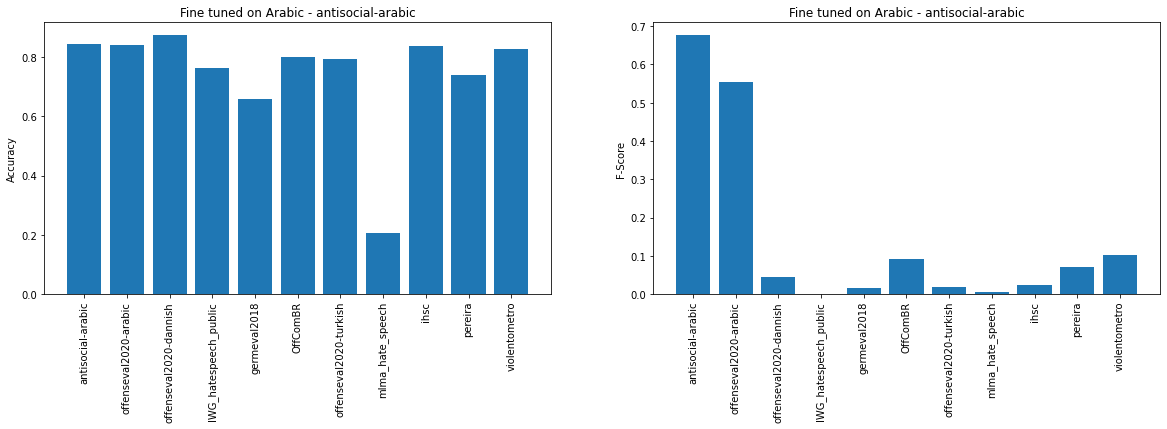

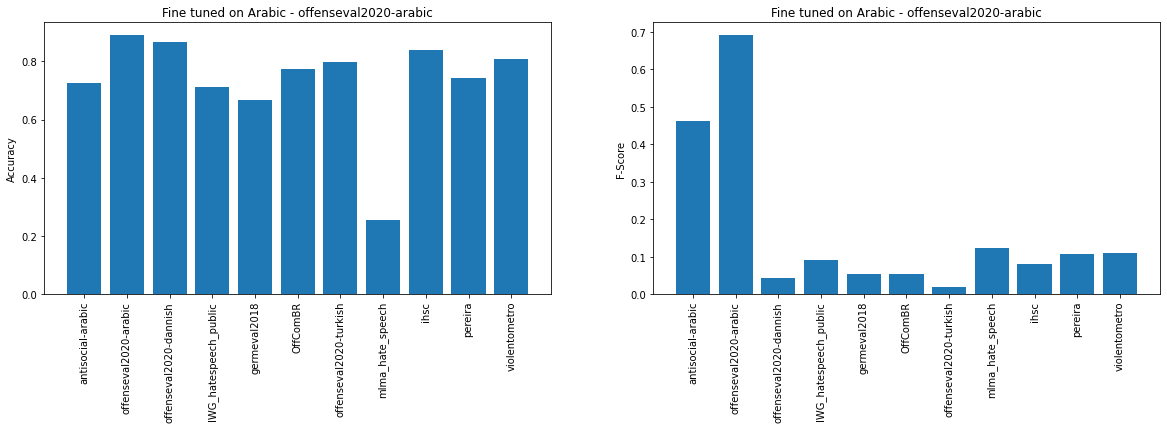

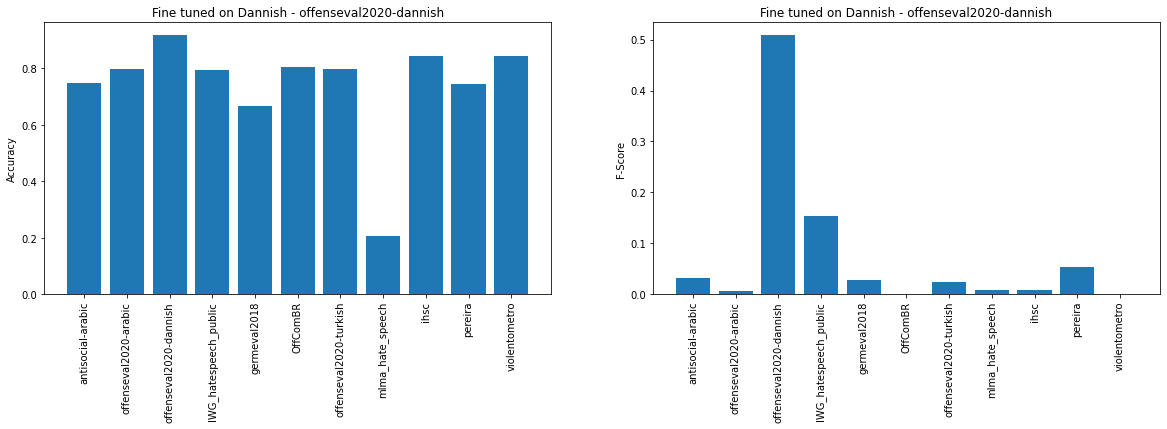

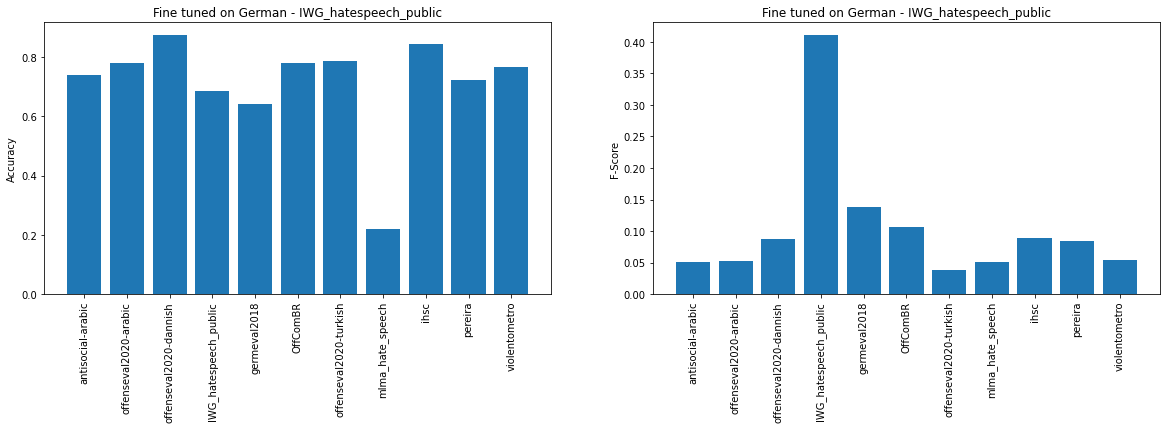

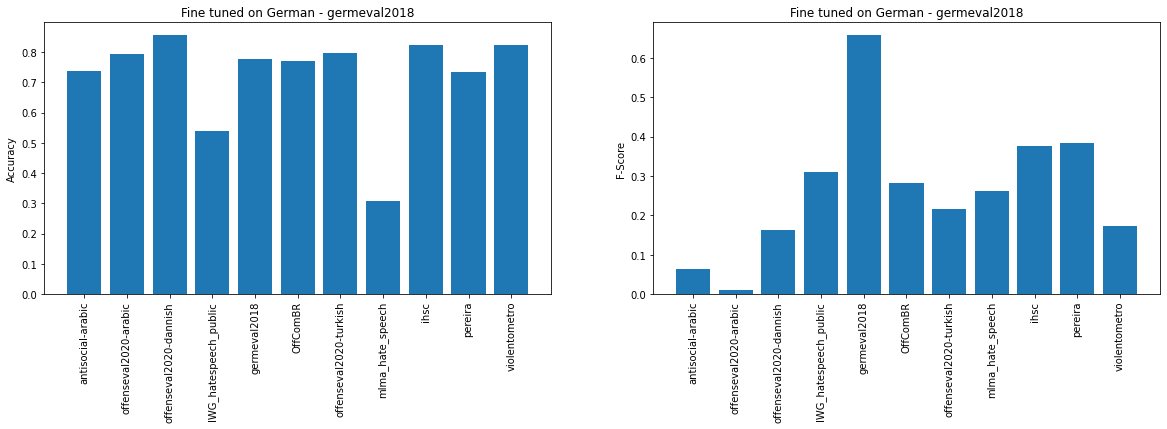

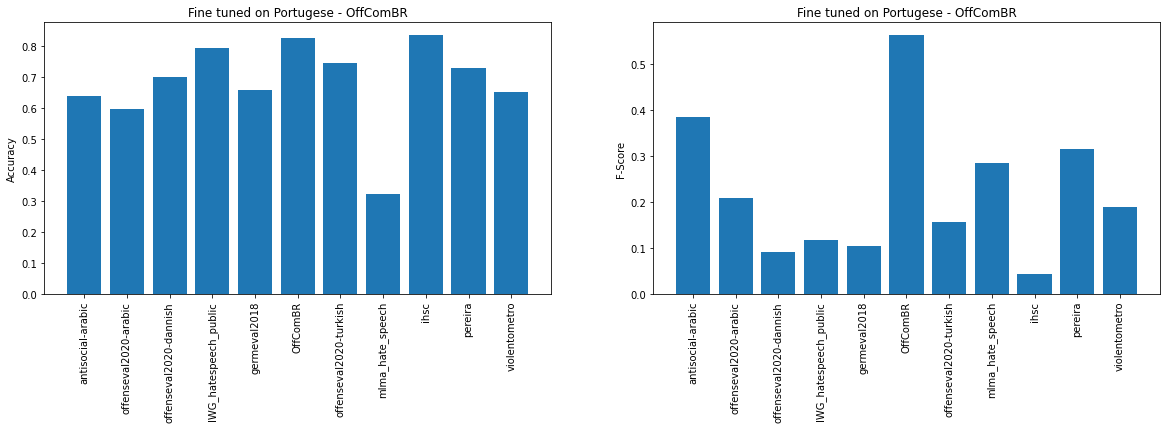

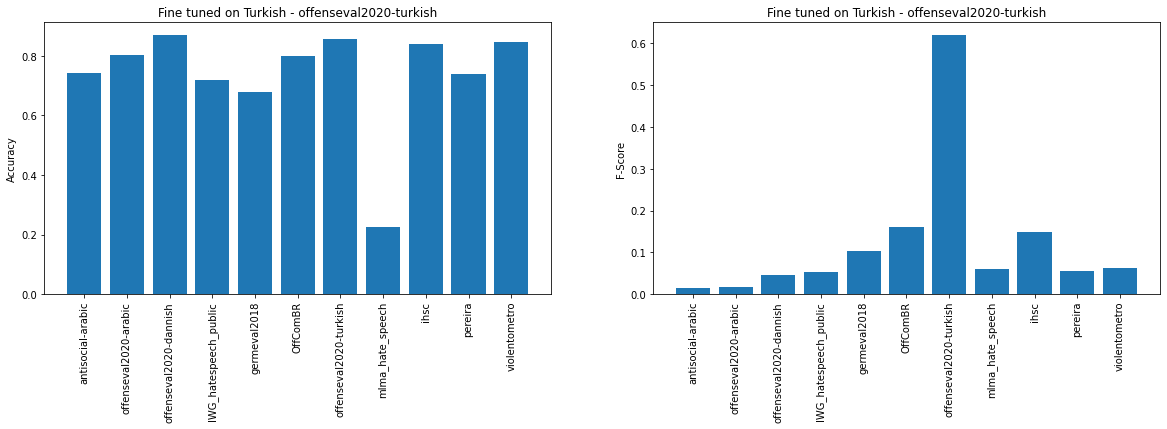

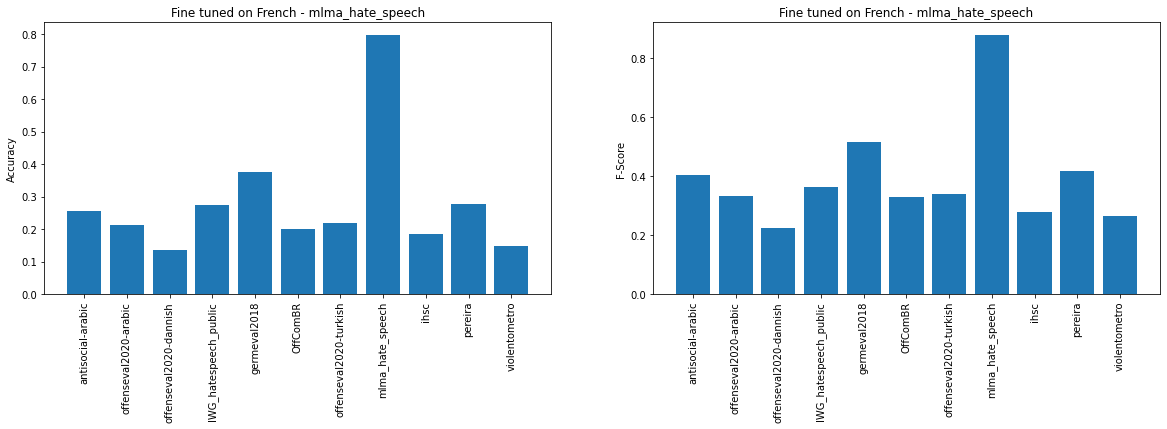

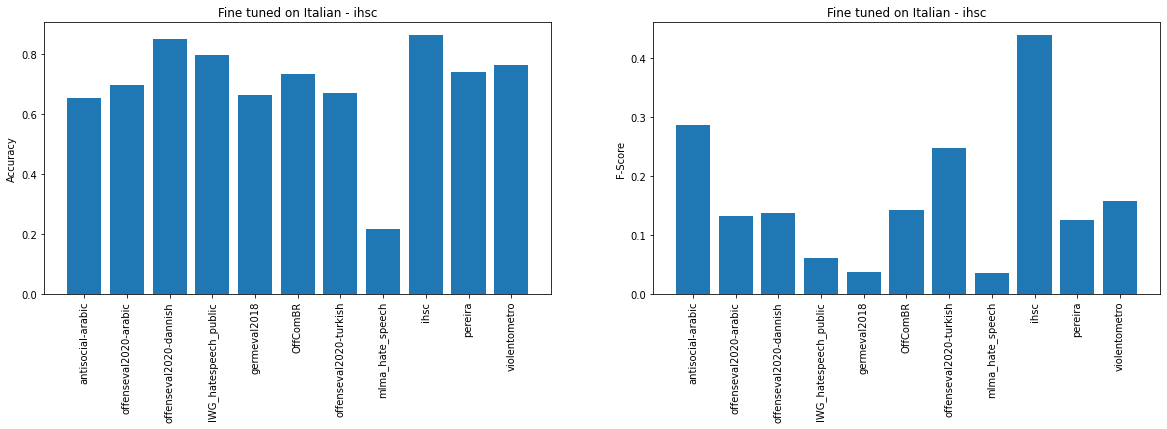

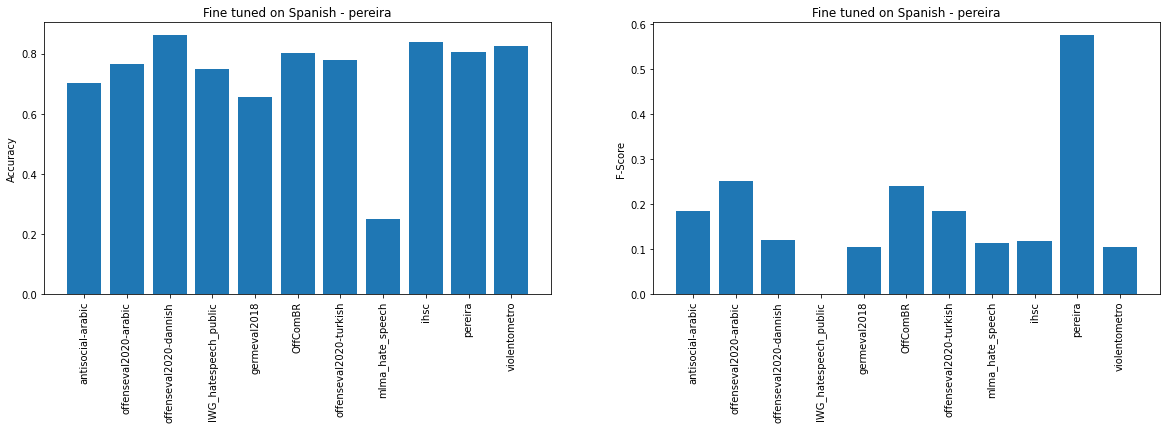

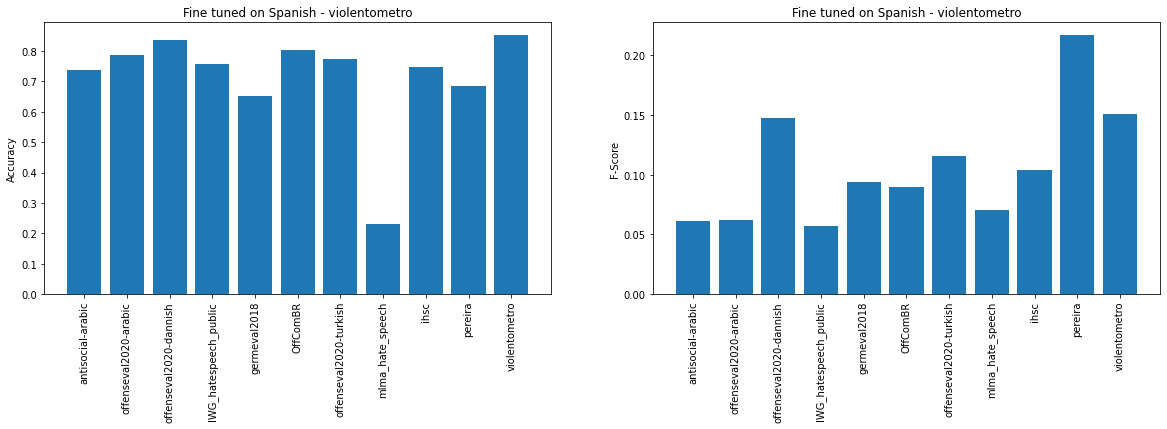

In [ ]:
# #train on one dataset, test on all 
# result={}
# for language in tensors.keys():
#   result[language]={}
#   for dataset in tensors[language].keys():
#       print("Training ", dataset)

#       result[language][dataset] ={}
#       model, optimizer, scheduler = trainMBert(tensors[language][dataset]['train'], dataset , epochs=10, validation_split=0.7)

#       for language2 in tensors.keys():
#         for dataset2 in tensors[language2].keys():
#           test_dataloader = tensors[language2][dataset2]['test']
#           train_loss,  train_acc , precision, recall, f_score,  _= train_validate( model, test_dataloader, scheduler, optimizer, train=False)
#           result[language][dataset][dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
#           print(language2, dataset2, train_acc , precision, recall, f_score)
      

with open("results.t", 'rb') as f:
  result = pickle.load(f)

for language in result.keys():
  for dataset in result[language].keys():
    res = result[language][dataset]
    plotResults(res, language, dataset)

Experiment 2 - Fine tuning on all training sets and testing on all testing sets

In [ ]:
#train on one dataset, test on all 
AllTraining=None
for language in tensors.keys():
    for dataset in tensors[language].keys():
      if AllTraining is None:
          AllTraining = tensors[language][dataset]['train'].dataset
      else:
          AllTraining = ConcatDataset([AllTraining,  tensors[language][dataset]['train'].dataset])

train_sampler = RandomSampler(AllTraining)
train_dataloader = torch.utils.data.DataLoader(AllTraining , sampler=train_sampler, batch_size=batch_size)

model, optimizer, scheduler = trainMBert(train_dataloader, 'AllDatasets' , epochs=10, validation_split=0.7)

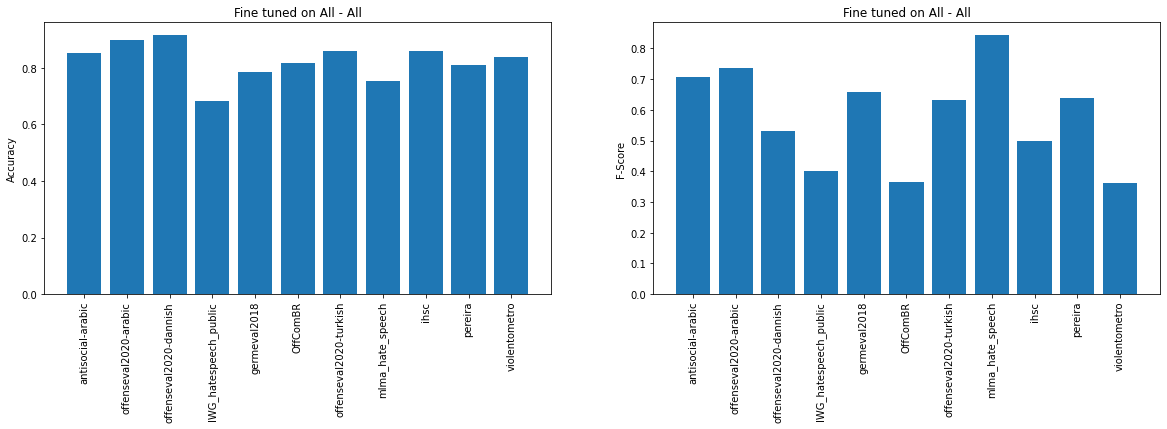

In [ ]:
Final ={}
for language2 in tensors.keys():
    for dataset2 in tensors[language2].keys():
          test_dataloader = tensors[language2][dataset2]['test']
          train_loss,  train_acc , precision, recall, f_score,  _= train_validate( model, test_dataloader, scheduler, optimizer, train=False)
          Final[dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
          print(language2, dataset2, train_acc , precision, recall, f_score)
language ="All"
dataset ="All"
plotResults(Final, language, dataset)   

### Model 2 - XLM-RoBERTa

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base', 
    num_labels = 2, # The number of output labels. 2 for binary classification.
)

# Send the model to the device.
model= model.to(device)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base') 
# max_seq_len = 64
# batch_size = 32
# tensors_roberta ={}
# for language in datasets.keys():
#   tensors_roberta[language] ={}
#   for dataset in datasets[language].keys():
#     tensors_roberta[language][dataset] ={}
#     X_train, y_train,  X_test, y_test = datasets[language][dataset]
#     train_dataloader, test_dataloader  = createDataLoader(X_train, y_train,  X_test, y_test,max_seq_len, batch_size)
#     tensors_roberta[language][dataset]['train'] = train_dataloader
#     tensors_roberta[language][dataset]['test'] = test_dataloader

# with open("datasets_roberta.dt", 'wb') as f:
#   pickle.dump(tensors_roberta, f, 4) 

with open("datasets_roberta.dt", 'rb') as f:
  tensors_roberta = pickle.load(f) 

from torch.utils.data import ConcatDataset
#train on one dataset, test on all 
AllTraining=None
for language in tensors_roberta.keys():
    for dataset in tensors_roberta[language].keys():
      if AllTraining is None:
          AllTraining = tensors_roberta[language][dataset]['train'].dataset
      else:
          AllTraining = ConcatDataset([AllTraining,  tensors_roberta[language][dataset]['train'].dataset])

train_sampler_roberta = RandomSampler(AllTraining)
train_dataloader_roberta = torch.utils.data.DataLoader(AllTraining , sampler=train_sampler_roberta, batch_size=batch_size)


In [ ]:
def train_validate_roberta( model, dataloader, scheduler, optimizer, train):
  if train: 
    model.train()
  else: 
    model.eval()

  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  i=0  
  acc=[]

  
  target_true =0
  predicted_true =0
  correct_true =0
  for step,batch in enumerate(dataloader):
    i+=1
    if step%20==0 and step != 0 and train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    if step%40==0 and step != 0 and not train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, label = batch

    if train:
      # clear previously calculated gradients 
      model.zero_grad()        

    with torch.set_grad_enabled(train): #only enable when training    
            
          outputs = model(sent_id, 
                    attention_mask=mask,
                    labels=label)
        
          loss = outputs[0]
                
          if train:
            loss.backward() 
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            optimizer.step()

           # Update the learning rate.
            scheduler.step()

    pred_score=outputs[1].detach().cpu().numpy()

    total_loss = total_loss + loss.item()
    acc.append(flat_accuracy(pred_score, label.detach().cpu().numpy()))

    predicted_classes = np.argmax(pred_score, axis=1).flatten()
    target_classes = label.detach().cpu().numpy().flatten()

    target_true += np.sum(target_classes)
    predicted_true += np.sum(predicted_classes)
    correct_true += np.sum((predicted_classes == target_classes) & (predicted_classes == 1))

    total_preds.append(pred_score)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  acc = np.mean(acc)
  
  recall = correct_true / target_true
  precision = correct_true / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss,acc, precision, recall, f1_score,  total_preds 

Experiment 2

In [ ]:
epochs=10
dataloader = train_dataloader_roberta
dataset_size = len(dataloader)
indices = list(range(dataset_size))
validation_split=0.7
split = int(np.floor(validation_split * dataset_size))

optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

total_steps = (dataset_size-split) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

train_losses=[]
#for each epoch
f_score_best=0
for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      

      try:       model.load_state_dict(torch.load('./models_ro/{}.pt'.format(dataset)))
      except: 1
      train_set, val_set = torch.utils.data.random_split(dataloader.dataset, lengths=[int(len(dataloader.dataset)*0.7), len(dataloader.dataset) - int(len(dataloader.dataset)*0.7)])

      train_sampler = RandomSampler(train_set)
      valid_sampler = RandomSampler(val_set)

      train_dataloader = torch.utils.data.DataLoader(train_set , sampler=train_sampler, batch_size=batch_size)

      validation_loader = torch.utils.data.DataLoader(val_set , 
                                                            sampler=valid_sampler, batch_size=batch_size)
      #train model

      train_loss,  train_acc , precision, recall, f_score,  _= train_validate_roberta( model, train_dataloader, scheduler, optimizer, train=True)

      train_loss,  train_acc , precision, recall, f_score,  _= train_validate_roberta( model, validation_loader, scheduler, optimizer, train=False)
      if f_score_best< f_score:
          torch.save(model.state_dict(), './models_ro/{}.pt'.format(dataset))
          print("updating")
          if  str(f_score)!='nan':
            f_score_best= f_score
            
      print(f'\nTraining Loss: {train_loss:.3f} Training Accuracy {train_acc:.3f}')
      print(f'\nPrecision: {precision:.3f} Recall {recall:.3f} F-Score {f_score:.3f}')
      # append training and validation loss
      train_losses.append(train_loss)


  Batch 40  of  106.
  Batch 80  of  106.
Arabic antisocial-arabic 0.8481300539083557 0.6713286713286714 0.7859649122807018 0.7241379310344828
  Batch 40  of  58.
Arabic offenseval2020-arabic 0.9100215517241379 0.7700534759358288 0.7804878048780488 0.7752355316285331
Dannish offenseval2020-dannish 0.8844696969696969 0.6 0.5853658536585366 0.5925925925925926
German IWG_hatespeech_public 0.7350961538461538 0.4375 0.65625 0.525
  Batch 40  of  47.
German germeval2018 0.8097331846259437 0.7316561844863732 0.6883629191321499 0.709349593495935
Portugese OffComBR 0.8238636363636364 0.5394736842105263 0.6721311475409836 0.5985401459854015
  Batch 40  of  110.
  Batch 80  of  110.
Turkish offenseval2020-turkish 0.867918771043771 0.6708160442600276 0.6821378340365682 0.6764295676429568
French mlma_hate_speech 0.7178101503759399 0.860302677532014 0.7705943691345151 0.812981298129813
  Batch 40  of  49.
Italian ihsc 0.8564228110599078 0.5387596899224806 0.5673469387755102 0.5526838966202784
  Batc

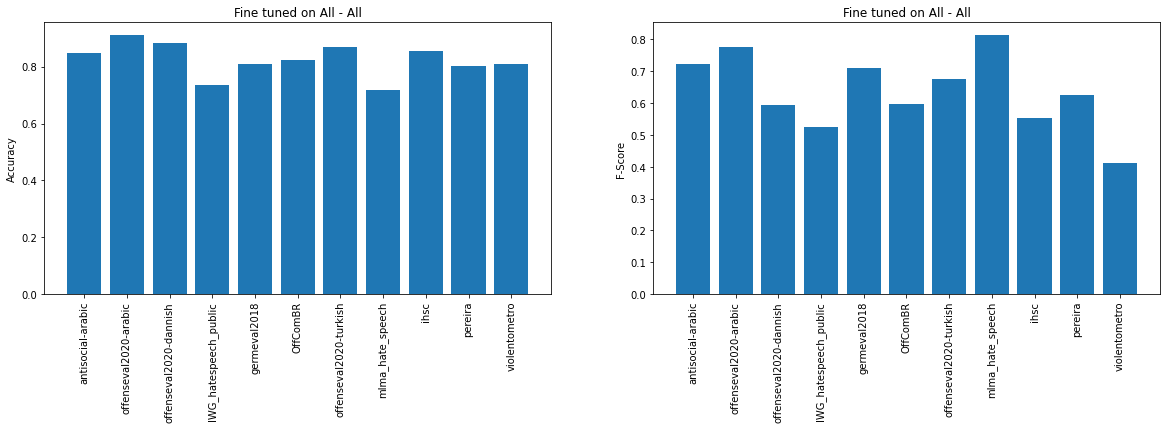

In [ ]:
Final ={}
for language2 in tensors_roberta.keys():
    for dataset2 in tensors_roberta[language2].keys():
          test_dataloader = tensors_roberta[language2][dataset2]['test']
          train_loss,  train_acc , precision, recall, f_score,  _= train_validate_roberta( model, test_dataloader, scheduler, optimizer, train=False)
          Final[dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
          print(language2, dataset2, train_acc , precision, recall, f_score)
language ="All"
dataset ="All"
plotResults(Final, language, dataset)

## Solution 2


This solution proposes to perform Knowledge Distillation for Profanity Detection. Here we are attempting to distill knowledge from French model to an Italian dataset.

Reads the French and Italian parallel datasets and creates an common datafrom from both.

In [ ]:
df1 =pd.read_csv('./Distillation/ihsc_it.csv')
df2 =pd.read_csv('./Distillation/ihsc_fr.csv')
df = pd.DataFrame()
df2 = df2[df2.index.isin(df1.index)]
df['input_it'] = df1['input']
df['input_fr'] = df2['input']
df['hate'] = df1['hate']

df = df.dropna()

max_seq_len = 64
batch_size = 32

#first is the teacher language, i,.e., french
X_train, y_train = fixImbalance(df.index, df['hate'])
df = df.iloc[X_train]
seq_train_first, mask_train_first = tokenize_encode_tensors(df["input_fr"].astype(str), max_seq_len)
seq_train_second, mask_train_second = tokenize_encode_tensors(df['input_it'], max_seq_len)

out_train = torch.tensor(y_train).long()
# wrap tensors

train_data = TensorDataset(seq_train_first, mask_train_first ,seq_train_second, mask_train_second,  out_train)
train_sampler = RandomSampler(train_data)
train_dataloader_all = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Prepares the models and dataloaders.

In [ ]:
mBertTeacher = BertModel.from_pretrained('bert-base-multilingual-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

mBertTeacher = freeze(mBertTeacher, 0)
teacher =ProfanityDetector_mBERT(mBertTeacher)
teacher = teacher.to(device)
teacher.load_state_dict(torch.load('./models/{}.pt'.format("ALLDatasets2")))

french_dataloader, italian_dataloader = createDataLoader(df2['input'].astype(str), df2['hate'], df1['input'].astype(str), df1['hate'], max_seq_len,batch_size)
# teacher, _, _ = trainMBert( french_dataloader, "french_italian", 10, 0.7, model=teacher)

teacher.bert =  freeze(teacher.bert, 20)
# torch.save(teacher.state_dict(), './models/{}.pt'.format("AllDatasetsFinedTunedOnFrench"))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprec

Freezing layer 0
Freezing layer 1
Freezing layer 2
Freezing layer 3
Freezing layer 4
Freezing layer 5
Freezing layer 6
Freezing layer 7
Freezing layer 8
Freezing layer 9
Freezing layer 10
Freezing layer 11


In [ ]:
mBertStudent = BertModel.from_pretrained('bert-base-multilingual-uncased')
mBertStudent = freeze(mBertStudent, 0)
student =ProfanityDetector_mBERT(mBertStudent)
student = student.to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
epochs=10
dataloader = train_dataloader_all
dataset_size = len(dataloader)
validation_split=0.7
split = int(np.floor(validation_split * dataset_size))
optimizer = AdamW(student.parameters(),
                    lr = 1e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )



  # Total number of training steps is number of batches * number of epochs.
total_steps = (dataset_size-split) * epochs

  # Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)

Defines a custom loss function to be used in training and defines the training and validation function for knowledge distillation.

In [ ]:
def train_validate_distilled( model, teacher,  dataloader, scheduler, optimizer, train):
  if train: 
    model.train()
  else: 
    model.eval()

  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  i=0  
  acc=[]

  mse = nn.MSELoss()
  target_true =0
  predicted_true =0
  correct_true =0
  for step,batch in enumerate(dataloader):
    i+=1
    if step%20==0 and step != 0 and train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    if step%40==0 and step != 0 and not train:
      print('  Batch {}  of  {}.'.format(step, len(dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    
    sent_id_first, mask_first, sent_id_second, mask_second, label = batch

    if train:
      # clear previously calculated gradients 
      model.zero_grad()        
      optimizer.zero_grad()
    target = teacher(sent_id_first, mask_first)
    with torch.set_grad_enabled(train): #only enable when training    
          pred_score_1 = model(sent_id_first, mask_first) # french
          pred_score_2 = model(sent_id_second, mask_second) #italian
    
          #before softmax
          loss =  my_loss(pred_score_2, target)  + my_loss(pred_score_1, target)  #+ my_loss(pred_score_1, target) 
          
          
          if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            optimizer.step()
            scheduler.step()
    # push model predictions from GPU to CPU
    pred_score=pred_score_2.detach().cpu().numpy()
    
    total_loss = total_loss + loss.item()
    acc.append(flat_accuracy(pred_score, label.detach().cpu().numpy()))

    
    predicted_classes = np.argmax(pred_score, axis=1).flatten()
    target_classes = label.detach().cpu().numpy().flatten()

    target_true += np.sum(target_classes)
    predicted_true += np.sum(predicted_classes)

    correct_true += np.sum((predicted_classes == target_classes) & (predicted_classes == 1))

    # append the model predictions
    total_preds.append(pred_score)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  acc = np.mean(acc)

  
  recall = correct_true / target_true
  precision = correct_true / predicted_true
  f1_score = 2 * precision * recall / (precision + recall)
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss,acc, precision, recall, f1_score,  total_preds 


In [ ]:
train_losses=[]
  #for each epoch

train_loss_best=1000
for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      

      try:  
        student.load_state_dict(torch.load('./models/distilled_{}.pt'.format("Experiment 2")))
      except: 1
      train_set, val_set = torch.utils.data.random_split(dataloader.dataset, lengths=[int(len(dataloader.dataset)*0.7), len(dataloader.dataset) - int(len(dataloader.dataset)*0.7)])

      train_sampler = RandomSampler(train_set)
      valid_sampler = RandomSampler(val_set)

      train_dataloader = torch.utils.data.DataLoader(train_set , sampler=train_sampler, batch_size=batch_size)

      validation_loader = torch.utils.data.DataLoader(val_set , sampler=valid_sampler, batch_size=batch_size)
      #train model
      train_loss,  train_acc , precision, recall, f_score,  _= train_validate_distilled( student, teacher, train_dataloader, scheduler, optimizer, train=True)
      train_loss,  train_acc , precision, recall, f_score,  _= train_validate_distilled( student, teacher, validation_loader, scheduler, optimizer, train=False)

      if train_loss_best> train_loss:
          torch.save(student.state_dict(), './models/distilled_{}.pt'.format("Experiment 2"))
          print("updating")
          train_loss_best= train_loss

      print(f'\nTraining Loss: {train_loss:.3f} Training Accuracy {train_acc:.3f}')

      train_losses.append(train_loss)

      Final ={}
      for language2 in tensors.keys():
          if language2 in ['Italian', 'French', 'Turkish']:
            for dataset2 in tensors[language2].keys():
                  test_dataloader = tensors[language2][dataset2]['test']
                  train_loss,  train_acc , precision, recall, f_score,  _= train_validate( student,  test_dataloader, scheduler, optimizer, train=False)
                  Final[dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
                  print(language2, dataset2, train_acc , precision, recall, f_score)
             




 Epoch 1 / 10
  Batch 20  of  193.
  Batch 40  of  193.
  Batch 60  of  193.
  Batch 80  of  193.
  Batch 100  of  193.
  Batch 120  of  193.
  Batch 140  of  193.
  Batch 160  of  193.
  Batch 180  of  193.
  Batch 40  of  83.
  Batch 80  of  83.
updating

Training Loss: 0.127 Training Accuracy 0.719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch 40  of  110.
  Batch 80  of  110.
Turkish offenseval2020-turkish 0.7629840067340068 0.39335664335664333 0.31645569620253167 0.35074045206547155
French mlma_hate_speech 0.48504072681704263 0.8803611738148984 0.40667361835245047 0.5563480741797433
  Batch 40  of  49.
Italian ihsc 0.8564228110599078 0.545045045045045 0.49387755102040815 0.5182012847965739

 Epoch 2 / 10
  Batch 20  of  193.
  Batch 40  of  193.
  Batch 60  of  193.
  Batch 80  of  193.
  Batch 100  of  193.
  Batch 120  of  193.
  Batch 140  of  193.
  Batch 160  of  193.
  Batch 180  of  193.
  Batch 40  of  83.
  Batch 80  of  83.
updating

Training Loss: 0.108 Training Accuracy 0.736
  Batch 40  of  110.
  Batch 80  of  110.
Turkish offenseval2020-turkish 0.7612794612794613 0.3926174496644295 0.3291139240506329 0.35807192042846214
French mlma_hate_speech 0.5042684837092731 0.8773388773388774 0.44004171011470283 0.5861111111111111
  Batch 40  of  49.
Italian ihsc 0.8564228110599078 0.540650406504065 0.5428571428

Plotting the results for the Italian test data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch 40  of  106.
  Batch 80  of  106.
Arabic antisocial-arabic 0.6309523809523809 0.3197781885397412 0.4046783625730994 0.35725348477026325
  Batch 40  of  58.
Arabic offenseval2020-arabic 0.7458692528735632 0.3560371517027864 0.3116531165311653 0.3323699421965318
Dannish offenseval2020-dannish 0.8207070707070708 0.3023255813953488 0.3170731707317073 0.30952380952380953
German IWG_hatespeech_public 0.7192307692307692 0.3076923076923077 0.25 0.27586206896551724
  Batch 40  of  47.
German germeval2018 0.7151896019217571 0.7365269461077845 0.24260355029585798 0.3649851632047477
Portugese OffComBR 0.7264204545454545 0.30357142857142855 0.2786885245901639 0.29059829059829057
  Batch 40  of  110.
  Batch 80  of  110.
Turkish offenseval2020-turkish 0.7743476430976431 0.4152892561983471 0.28270042194092826 0.3364016736401674
French mlma_hate_speech 0.48993577694235596 0.8739130434782608 0.4191866527632951 0.5665961945031712
  Batch 40  of  49.
Italian ihsc 0.8690956221198157 0.586956521739

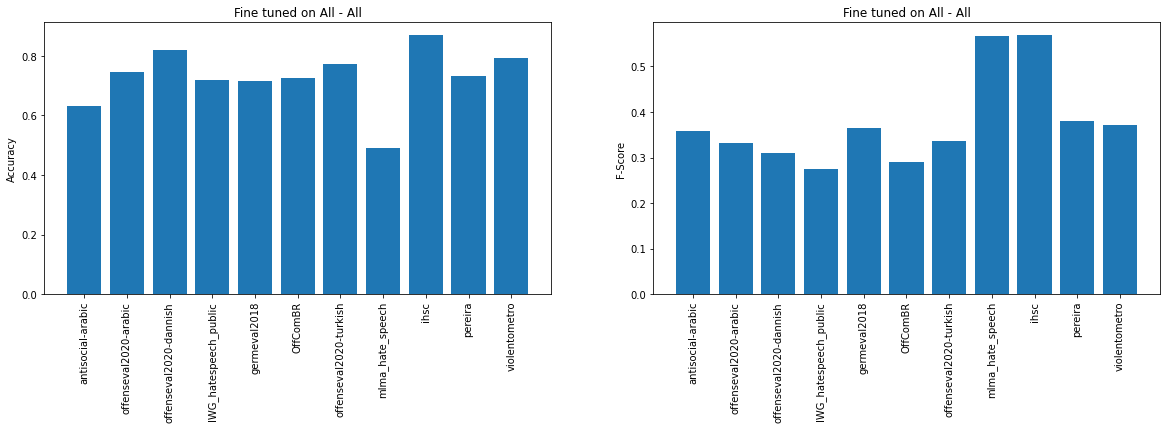

In [ ]:
Final ={}
for language2 in tensors.keys():
      for dataset2 in tensors[language2].keys():
            test_dataloader = tensors[language2][dataset2]['test']
            train_loss,  train_acc , precision, recall, f_score,  _= train_validate( student,  test_dataloader, scheduler, optimizer, train=False)
            Final[dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
            print(language2, dataset2, train_acc , precision, recall, f_score)
        
language ="All"
dataset ="All"
plotResults(Final, language, dataset)

Plotting the results for the teacher model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Batch 40  of  106.
  Batch 80  of  106.
Arabic antisocial-arabic 0.8390049415992812 0.6631689401888772 0.7391812865497076 0.6991150442477876
  Batch 40  of  58.
Arabic offenseval2020-arabic 0.8913433908045977 0.7595307917888563 0.7018970189701897 0.7295774647887324
Dannish offenseval2020-dannish 0.8945707070707072 0.7142857142857143 0.36585365853658536 0.4838709677419355
German IWG_hatespeech_public 0.7504807692307692 0.43243243243243246 0.5 0.463768115942029
  Batch 40  of  47.
German germeval2018 0.773121139327385 0.6912442396313364 0.591715976331361 0.6376195536663125
Portugese OffComBR 0.8039772727272727 0.5102040816326531 0.4098360655737705 0.45454545454545453
  Batch 40  of  110.
  Batch 80  of  110.
Turkish offenseval2020-turkish 0.8451914983164983 0.6114819759679573 0.6441631504922645 0.6273972602739726
French mlma_hate_speech 0.8149279448621554 0.9328621908127208 0.8258602711157456 0.8761061946902655
  Batch 40  of  49.
Italian ihsc 0.9138207702435812 0.7131782945736435 0.75

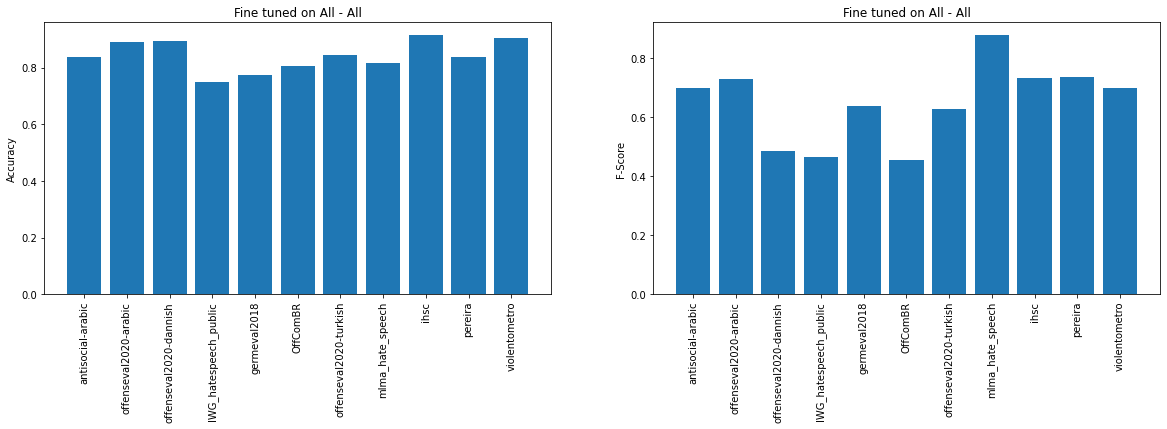

In [ ]:
Final ={}
for language2 in tensors.keys():
      for dataset2 in tensors[language2].keys():
            test_dataloader = tensors[language2][dataset2]['test']
            train_loss,  train_acc , precision, recall, f_score,  _= train_validate( teacher,  test_dataloader, scheduler, optimizer, train=False)
            Final[dataset2]= {'accuracy':train_acc, 'precision':precision, 'recall': recall, 'f_score': f_score}
            print(language2, dataset2, train_acc , precision, recall, f_score)
        
language ="All"
dataset ="All"
plotResults(Final, language, dataset)